In [21]:
import torch
torch.cuda.empty_cache()
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [22]:
# hyper parameters
BATCH_SIZE = 3
LEARNING_RATE = 0.0001
IMAGE_SIZE = 160

## Define UNET
https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

In [23]:


# create model
import torch

import torch.nn as nn
import torch.nn.functional as F
import lstm_unet

        


model = lstm_unet.UNet(1,2).to(dev)
#model.load_state_dict(torch.load("lstm_unetCroped.pt",map_location=dev))
#model(torch.rand((1,1 ,1, IMAGE_SIZE, IMAGE_SIZE)).to(dev)).shape

<All keys matched successfully>

## Prepare dataloaders

In [24]:
import pandas as pd

dataset = pd.read_json("./data/dataset_seq.json")
dataset = dataset.sample(frac=1,random_state=0)[:] # shuffle
#dataset = dataset[:500].copy()
split = int(len(dataset) * 0.9)
train_df = dataset[1:split].copy()
test_df =  dataset[split:].copy()
train_df


,seqence,anot,path
1590,"[data\train\BF-C2DL-MuSC\02\t0218.tif, data\tr...",[data\train\BF-C2DL-MuSC\02_ST\SEG\man_seg0218...,data\train\BF-C2DL-MuSC\02\t0222.tif
2380,"[data\train\BF-C2DL-MuSC\02\t1008.tif, data\tr...",[data\train\BF-C2DL-MuSC\02_ST\SEG\man_seg1008...,data\train\BF-C2DL-MuSC\02\t1012.tif
2444,"[data\train\BF-C2DL-MuSC\02\t1072.tif, data\tr...",[data\train\BF-C2DL-MuSC\02_ST\SEG\man_seg1072...,data\train\BF-C2DL-MuSC\02\t1076.tif
1147,"[data\train\BF-C2DL-MuSC\01\t1147.tif, data\tr...",[data\train\BF-C2DL-MuSC\01_ST\SEG\man_seg1147...,data\train\BF-C2DL-MuSC\01\t1151.tif
1231,"[data\train\BF-C2DL-MuSC\01\t1231.tif, data\tr...",[data\train\BF-C2DL-MuSC\01_ST\SEG\man_seg1231...,data\train\BF-C2DL-MuSC\01\t1235.tif
...,...,...,...
606,"[data\train\BF-C2DL-MuSC\01\t0606.tif, data\tr...",[data\train\BF-C2DL-MuSC\01_ST\SEG\man_seg0606...,data\train\BF-C2DL-MuSC\01\t0610.tif
164,"[data\train\BF-C2DL-MuSC\01\t0164.tif, data\tr...",[data\train\BF-C2DL-MuSC\01_ST\SEG\man_seg0164...,data\train\BF-C2DL-MuSC\01\t0168.tif
2154,"[data\train\BF-C2DL-MuSC\02\t0782.tif, data\tr...",[data\train\BF-C2DL-MuSC\02_ST\SEG\man_seg0782...,data\train\BF-C2DL-MuSC\02\t0786.tif
1040,"[data\train\BF-C2DL-MuSC\01\t1040.tif, data\tr...",[data\train\BF-C2DL-MuSC\01_ST\SEG\man_seg1040...,data\train\BF-C2DL-MuSC\01\t1044.tif


In [25]:
from torchvision.transforms import transforms, Lambda
import albumentations as A
from albumentations.pytorch import ToTensorV2

CROP_NON_EMPTY_CHANCE = 0.7
transform_train = A.Compose([

                        # augmentation 

                        A.CropNonEmptyMaskIfExists(IMAGE_SIZE, IMAGE_SIZE,p=CROP_NON_EMPTY_CHANCE),
                        A.RandomCrop(IMAGE_SIZE, IMAGE_SIZE,always_apply=True),       
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5),
                        A.ShiftScaleRotate(rotate_limit=90,shift_limit=0.25,border_mode=0),

                        
                        # preprocessing
           
                        
                        ToTensorV2(),
                        ] 
                        ,additional_targets={ 'image1': 'image','image2': 'image','image3': 'image','image4': 'image'
                                             ,'mask1': 'mask','mask2': 'mask','mask3': 'mask','mask4': 'mask'}  
                    )

transform_test = A.Compose([

                        # I know random transformation for testing is to ideal
                        A.CropNonEmptyMaskIfExists(IMAGE_SIZE, IMAGE_SIZE,p=CROP_NON_EMPTY_CHANCE ),
                        A.RandomCrop(IMAGE_SIZE, IMAGE_SIZE,always_apply=True),
                        ToTensorV2(),
                    ]   
                     ,additional_targets={ 'image1': 'image','image2': 'image','image3': 'image','image4': 'image'
                                             ,'mask1': 'mask','mask2': 'mask','mask3': 'mask','mask4': 'mask'}  
                    )


# ==== Augmentations used for full frame training ====
# transform_train = A.Compose([


#                         A.Resize(IMAGE_SIZE, IMAGE_SIZE,always_apply=True),
#                         A.HorizontalFlip(p=0.5),
#                         A.VerticalFlip(p=0.5),
#                         A.ShiftScaleRotate(rotate_limit=90,shift_limit=0.25,border_mode=0),

                        
#                         # preprocessing
           
                        
#                         ToTensorV2(),
#                         ] 
#                         ,additional_targets={ 'image1': 'image','image2': 'image','image3': 'image','image4': 'image'
#                                              ,'mask1': 'mask','mask2': 'mask','mask3': 'mask','mask4': 'mask'}  
#                     )

# transform_test = A.Compose([
#                         # A.CropNonEmptyMaskIfExists(IMAGE_SIZE, IMAGE_SIZE,p=CROP_NON_EMPTY_CHANCE ),
#                         # A.RandomCrop(IMAGE_SIZE, IMAGE_SIZE,always_apply=True),
#                         A.Resize(IMAGE_SIZE, IMAGE_SIZE,always_apply=True),
#                        # A.CropNonEmptyMaskIfExists(IMAGE_SIZE, IMAGE_SIZE,always_apply=True ),
#                         ToTensorV2(),
#                     ]   
#                      ,additional_targets={ 'image1': 'image','image2': 'image','image3': 'image','image4': 'image'
#                                              ,'mask1': 'mask','mask2': 'mask','mask3': 'mask','mask4': 'mask'}  
#                     )




torch.Size([5, 1, 160, 160])


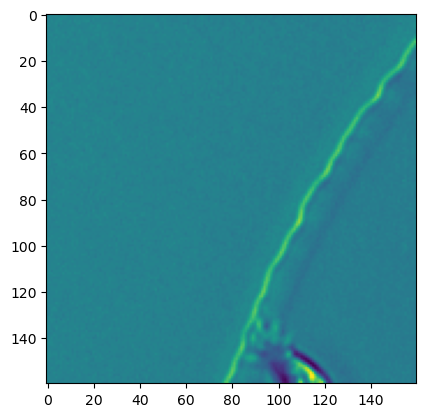

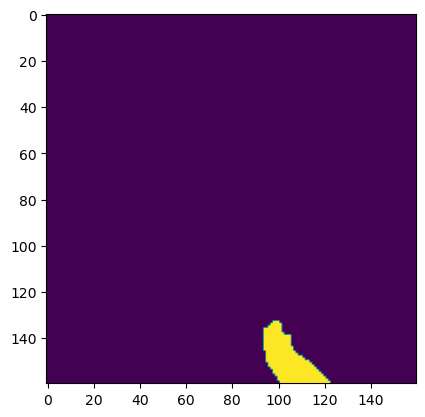

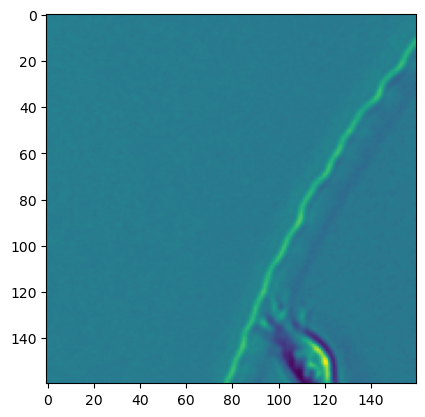

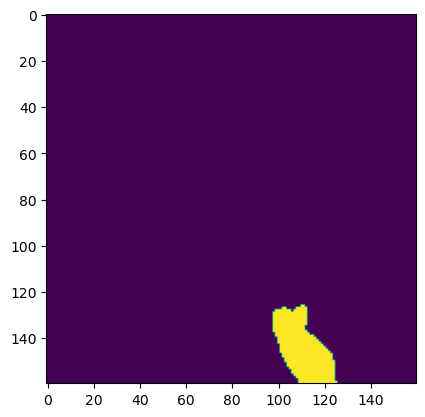

In [26]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import matplotlib.pyplot as plt
from skimage import color, io
import numpy as np

class CellSegmentationDataset(Dataset):
    def __init__(self, data, transform):
        super().__init__()
        self.data = data
        self.transform = transform
        self.to_tensor = transforms.ToTensor()
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        imgs = []
        anots =[]
        # load every image in sequence
        for p in zip(self.data["seqence"].iloc[idx], self.data["anot"].iloc[idx]):
            image_filepath = p[0]
            mask_filepath = p[1]
            img =  io.imread(image_filepath).astype(np.uint8)
            mask = io.imread(mask_filepath).astype(np.uint8)
            imgs.append(img)
            anots.append(mask)
        # transform
        transformed = self.transform(image=imgs[0],image1=imgs[1],image2=imgs[2],image3=imgs[3],image4=imgs[4],
                       mask=anots[0],mask1=anots[1],mask2=anots[2],mask3=anots[3],mask4=anots[4])
       
        image = torch.stack([transformed["image"],transformed["image1"],transformed["image2"],transformed["image3"],transformed["image4"]])
        anot =  torch.stack([transformed["mask"],transformed["mask1"],transformed["mask2"],transformed["mask3"],transformed["mask4"]]) > 0
        return image, anot.long()
    
train_ds = CellSegmentationDataset(train_df, transform_train)
test_ds = CellSegmentationDataset(test_df, transform_test)
idx = 100#1500
out = train_ds[idx]
print(out[0].shape)

# test if it works
plt.imshow(out[0][0][0].numpy())
plt.show()
plt.imshow(out[1][0].numpy())
plt.show()

plt.imshow(out[0][1][0].numpy())
plt.show()
plt.imshow(out[1][1].numpy())
plt.show()



In [27]:
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,
                                            shuffle=True,pin_memory = True)

testloader = torch.utils.data.DataLoader(test_ds, batch_size=1,
                                        shuffle=False)


#model(next(iter(trainloader))[0])[:,-1,...].shape

## Training

In [28]:
loss_func = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [29]:
from tqdm.notebook import tqdm
from torchmetrics import JaccardIndex
def train_one_epoch(model, epoch_index, trainloader, opt, loss_func):
    running_loss = 0.
    last_loss = 0.

    model.train()
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader), leave=True, position=0):
        inputs, anot = data[0].to(dev), data[1].to(dev)

        opt.zero_grad()
        outputs = model(inputs)

        B, S, C, W,H = outputs.shape
        outputs = outputs.view(B*S,C,W,H)
        anot = anot.view(B*S,W,H)

        loss = loss_func(outputs, anot)
        loss.backward()
        opt.step()

        # Gather data and report
        running_loss += loss.item() / len(trainloader)

    return running_loss


def eval(model, testLoader):
    model.eval()
    total_loss = 0
    jc = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testLoader), total=len(testLoader), leave=True, position=0):
            inputs, anot = data[0].to(dev), data[1].to(dev)
            outputs = model(inputs)
            B, S, C, W,H = outputs.shape
            outputs = outputs.view(B*S,C,W,H)
            anot = anot.view(B*S,W,H)
            loss = loss_func(outputs, anot)
            total_loss += loss.item() / len(testloader)
            
            outputs_th = outputs[-1][1] > 0.5
            jaccard = JaccardIndex(num_classes=2,task="binary")
            j = jaccard(outputs_th.to("cpu"), anot[-1].to("cpu")) / len(testloader)
            if not torch.isnan(j):
                jc += j


    return total_loss, jc

In [ ]:
epochs = 15
torch.cuda.empty_cache()
for epoch in tqdm(range(0, epochs), total=epochs):
    train_loss = train_one_epoch(model, epoch, trainloader, opt, loss_func)
    valid_loss,jc = eval(model, testloader)
   #
    print(epoch, "Training loss:", train_loss,"Valid loss:", valid_loss,jc)

torch.save(model.state_dict(), "lstm_unet1.pt")

(5, 1, 2, 160, 160) 0.99089676


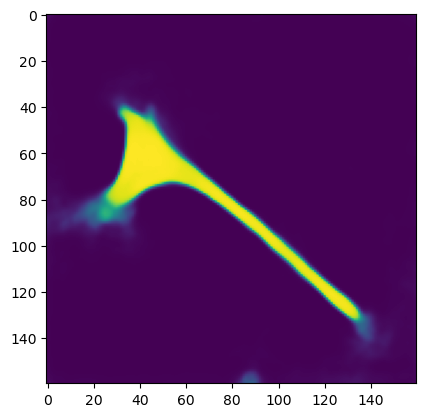

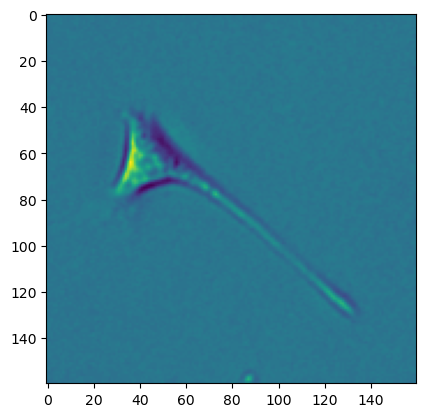

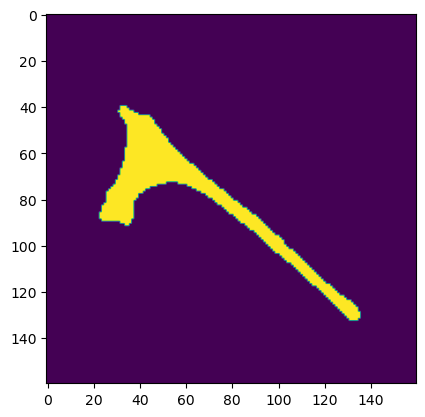

In [31]:
# test the results

with torch.no_grad():
    torch.cuda.empty_cache()
    a,b = test_ds[101]
    res = model(a[:,None].to(dev))
    res = torch.sigmoid(res)
    res = res.detach().cpu().numpy()
    index = -1
    bg, fg = res[index,0]
    print(res.shape,np.max(fg))

    plt.imshow(fg)
    plt.show()

    plt.imshow(a[index][0])
    plt.show()

    plt.imshow(b[index])
    plt.show()

